In [1]:
import sys

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dog-vs-cat-classification"))

['sample_submission.csv', 'test', 'train']


In [4]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [6]:
filenames = os.listdir('./dog-vs-cat-classification/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [7]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [8]:
df.tail()

,filename,category
24997,dog.9996.jpg,1
24998,dog.9997.jpg,1
24999,dog.9998.jpg,1
25000,dog.9999.jpg,1
25001,dogs,0


<AxesSubplot:>

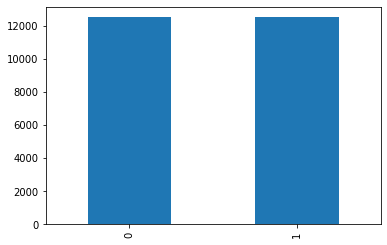

In [9]:
df['category'].value_counts().plot.bar()

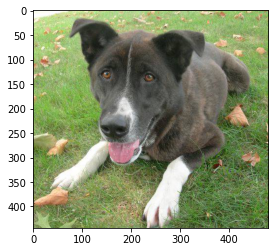

In [10]:
random.seed(2022)

sample = random.choice(filename_cats)
image = load_img("./dog-vs-cat-classification/train/"+sample)
plt.imshow(image)
plt.show()

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# model = Sequential([
#     # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
#     Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     MaxPooling2D(2, 2), 
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2), 
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2), 
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2), 
#     # 2D -> 1D로 변환을 위하여 Flatten 합니다.
#     Flatten(), 
#     # 과적합 방지를 위하여 Dropout을 적용합니다.
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     # Classification을 위한 Softmax 
#     # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지마세요!
#     Dense(3, activation='softmax'),
# ])

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.00001)

In [20]:
callbacks = [earlystop, learning_rate_reduction]

In [21]:
df['category'] = df['category'].replace({0: 'cat', 1:'dog'})

In [22]:
# train - validation 데이터 분리

train_df, validate_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

<AxesSubplot:>

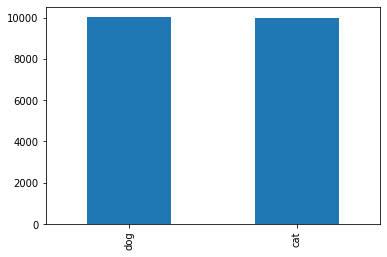

In [23]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

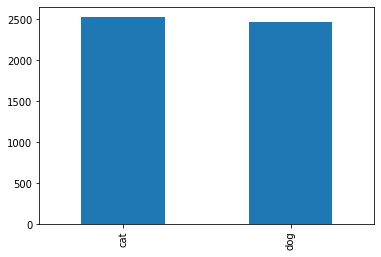

In [24]:
validate_df['category'].value_counts().plot.bar()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    './dog-vs-cat-classification/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 19999 validated image filenames belonging to 2 classes.


In [27]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    './dog-vs-cat-classification/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 5001 validated image filenames belonging to 2 classes.


In [28]:
example_df = train_df.sample(n=1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    './dog-vs-cat-classification/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1 validated image filenames belonging to 1 classes.


In [29]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1333/1333 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.6316WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025A0CBE5168> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

1333/1333 [==============================] - 98s 74ms/step - loss: 0.3348 - accuracy: 0.8572 - val_loss: 0.2448 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 17/50
1333/1333 [==============================] - 100s 75ms/step - loss: 0.3231 - accuracy: 0.8627 - val_loss: 0.4778 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 18/50
1333/1333 [==============================] - 85s 64ms/step - loss: 0.3223 - accuracy: 0.8633 - val_loss: 0.3214 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 19/50
1333/1333 [==============================] - 76s 57ms/step - loss: 0.3109 - accuracy: 0.8680 - val_loss: 0.2958 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 20/50
1333/1333 [==============================] - 75s 56ms/step - loss: 0.3091 - accuracy: 0.8712 - val_loss: 0.3535 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 21/50
1333/1333 [==============================] - 75s 57ms/step - loss: 0.3119 - accuracy: 0.8674 - val_loss: 0.2377 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 22/50
1333/1333 [============================

1333/1333 [==============================] - 77s 58ms/step - loss: 0.2795 - accuracy: 0.8842 - val_loss: 0.2481 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 37/50
1333/1333 [==============================] - 76s 57ms/step - loss: 0.2806 - accuracy: 0.8841 - val_loss: 0.2491 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 38/50
1333/1333 [==============================] - 76s 57ms/step - loss: 0.2812 - accuracy: 0.8849 - val_loss: 0.2141 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 39/50
1333/1333 [==============================] - 76s 57ms/step - loss: 0.2705 - accuracy: 0.8900 - val_loss: 0.2741 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 40/50
1333/1333 [==============================] - 75s 57ms/step - loss: 0.2724 - accuracy: 0.8879 - val_loss: 0.3164 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 41/50
1333/1333 [==============================] - 75s 57ms/step - loss: 0.2641 - accuracy: 0.8907 - val_loss: 0.2053 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 42/50
1333/1333 [=============================

In [30]:
model.save_weights('model.h5')

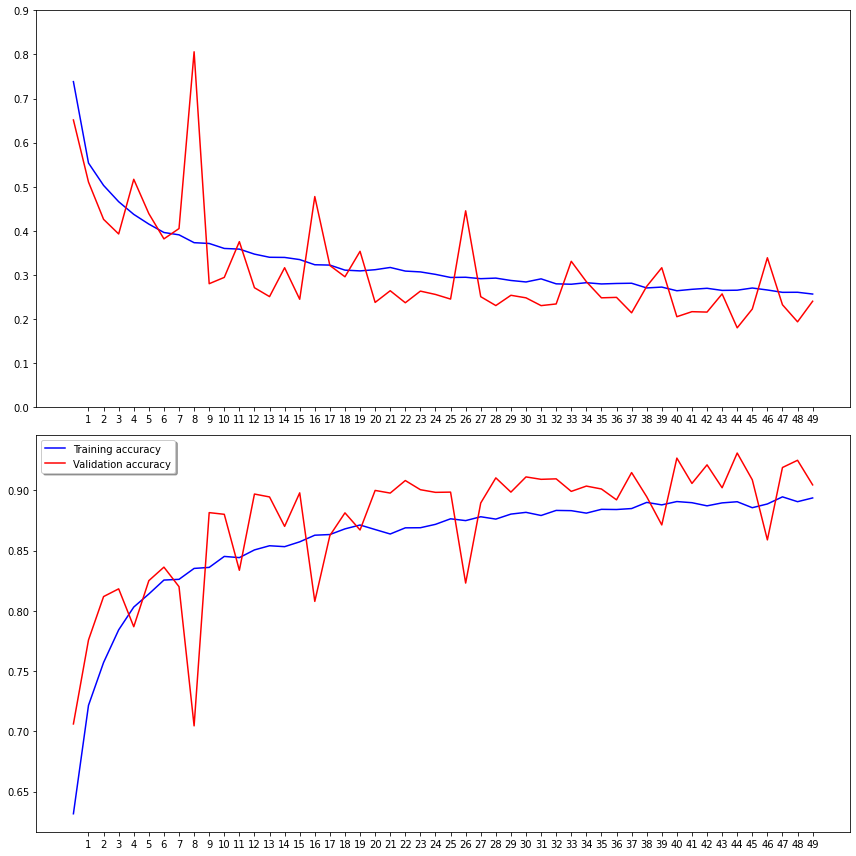

In [34]:
# 학습 내용 확인

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], color = 'b', label = 'Training loss')
ax1.plot(history.history['val_loss'], color = 'r', label = 'validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
ax2.plot(history.history['val_accuracy'], color = 'r', label = 'Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()